In [1]:
import shutil
import os

if os.path.exists("logs"):
    shutil.rmtree("logs")
    print("Logs directory cleared")
else:
    print("No logs directory found")

Logs directory cleared


In [2]:
from utils import start_tensorboard

start_tensorboard()

⚠️  Warning: Logs directory not found at /Users/stas/my_git/ndl/assignments/solution_4/logs


# Fully Connected Neural Networks: Part 2 - First Image Classification
After getting to know a basic assortment of layer types and activation functions, we will switch our task to image classification, showing some of the limitations of pure fully connected (dense) neural networks. We will evaluate a moderately deep network with a quite standard layout and do some basic random paramter and achritecture search.


In [3]:
# load data
import keras
import numpy as np
from skimage.transform import resize
from sklearn.model_selection import train_test_split  # FIX: import for explicit split


sym_dim=8
# (X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()  # OLD
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()  # FIX: renamed

# X_train = X_train.reshape(-1, 28 * 28).astype("float32") / 255.0  # OLD
X_train_full = X_train_full.reshape(-1, 28 * 28).astype("float32") / 255.0  # FIX: renamed
X_test = X_test.reshape(-1, 28 * 28).astype("float32") / 255.0 #same for test


# X_train = resize(X_train.reshape(-1, 28, 28), (len(X_train), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")  # OLD
X_train_full = resize(X_train_full.reshape(-1, 28, 28), (len(X_train_full), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")  # FIX: renamed
X_test = resize(X_test.reshape(-1, 28, 28), (len(X_test), sym_dim, sym_dim)).reshape(-1, sym_dim*sym_dim).astype("float32")

# FIX: explicit train/val split to avoid data leak (validation_split uses last 20% deterministically)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full
)

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"X_val: {X_val.shape}, y_val: {y_val.shape}")  # FIX: added
print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")
# print(f"Classes: {np.unique(y_train)}")  # OLD: removed

X_train: (48000, 64), y_train: (48000,)
X_val: (12000, 64), y_val: (12000,)
X_test: (10000, 64), y_test: (10000,)


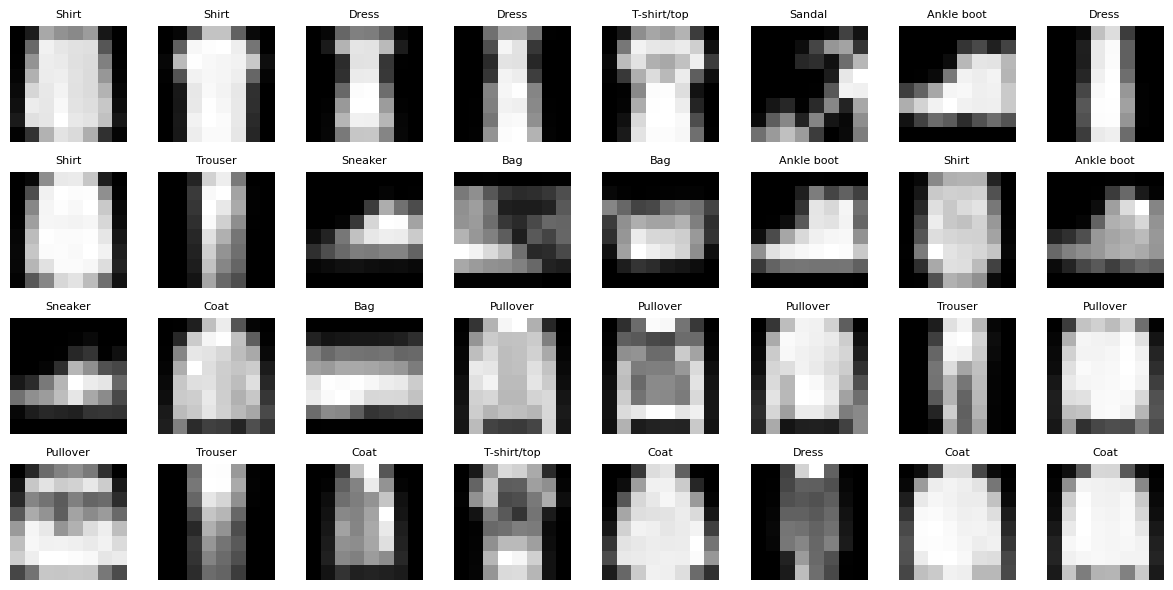

In [4]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i].reshape(sym_dim, sym_dim), cmap='gray')
    ax.set_title(class_names[y_train[i]], fontsize=8)
    ax.axis('off')
plt.tight_layout()
plt.show()

In [5]:
def create_fcnn(
    input_dim: int,
    num_classes: int,
    hidden_layers: list[int] = [512, 256, 128],
    dropout_rate: float = 0.3,
    learning_rate: float = 0.001,  # NEW
    optimizer: str = "adam",       # NEW
    name: str = "fcnn"
) -> keras.Model:
    
    inputs = keras.layers.Input(shape=(input_dim,))
    x = inputs
    
    for i, units in enumerate(hidden_layers):
        x = keras.layers.Dense(units)(x)
        x = keras.layers.Activation("relu")(x)
        if dropout_rate > 0:
            x = keras.layers.Dropout(dropout_rate)(x)
    
    outputs = keras.layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    
    # NEW: select optimizer based on parameter
    if optimizer == "adam":
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    elif optimizer == "sgd":
        opt = keras.optimizers.SGD(learning_rate=learning_rate)
    elif optimizer == "rmsprop":
        opt = keras.optimizers.RMSprop(learning_rate=learning_rate)
    else:
        opt = keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(
        optimizer=opt,
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

In [6]:
basic_model = create_fcnn(
    input_dim=sym_dim*sym_dim,
    num_classes=10,
    hidden_layers=[512, 256, 128],
    dropout_rate=0.3,
    name="fashion_fcnn"
)
basic_model.summary()

Model: "fashion_fcnn"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │        33,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,794 (776.54 KB)

 Trainable params: 198,794 (776.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.7445 - loss: 0.7006 - val_accuracy: 0.8169 - val_loss: 0.5029
Epoch 2/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 1s 980us/step - accuracy: 0.8078 - loss: 0.5224 - val_accuracy: 0.8332 - val_loss: 0.4496
Epoch 3/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8225 - loss: 0.4836 - val_accuracy: 0.8472 - val_loss: 0.4202
Epoch 4/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8299 - loss: 0.4603 - val_accuracy: 0.8446 - val_loss: 0.4184
Epoch 5/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8351 - loss: 0.4441 - val_accuracy: 0.8594 - val_loss: 0.3810
Epoch 6/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8404 - loss: 0.4303 - val_accuracy: 0.8601 - val_loss: 0.3772
Epoch 7/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 996us/step - accuracy: 0.8443 - loss: 0.4210 - val_accuracy: 0.8631 - val_loss: 0.3833
Epoch 8/10
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.8476 - loss: 0.413

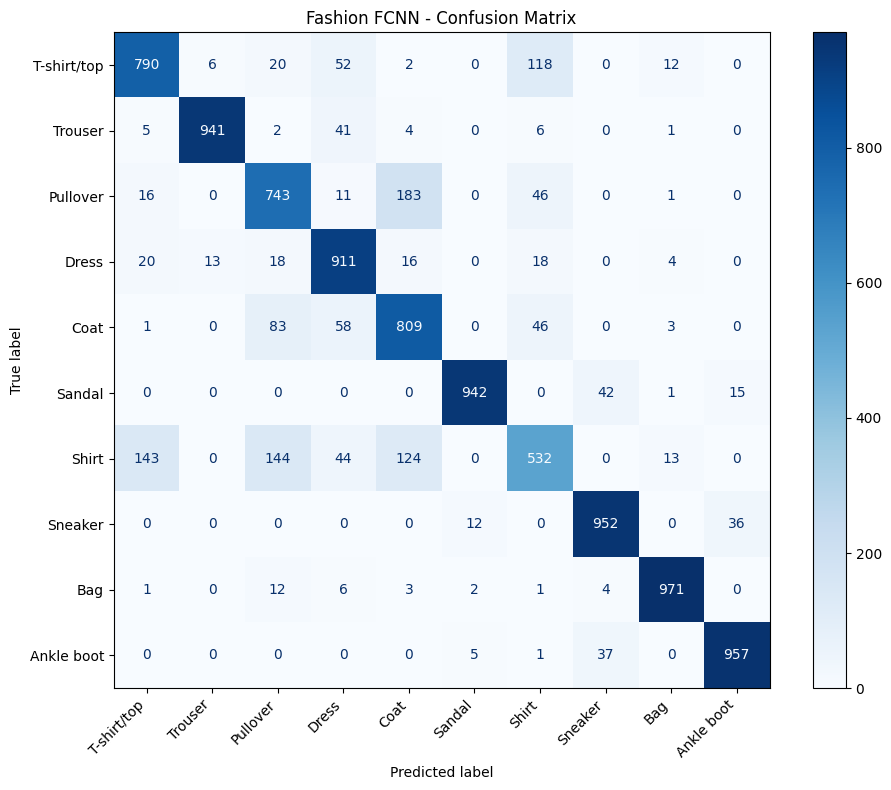

(0.3832017183303833, 0.8547999858856201)

In [7]:
from utils import train_model, eval_classification

# basic_fcnn_history = train_model(basic_model, X_train, y_train, "basic_functional_api", epochs=10)  # OLD
basic_fcnn_history = train_model(basic_model, X_train, y_train, "basic_functional_api", (X_val, y_val), epochs=10)  # FIX: validation_data is now required
eval_classification(basic_model, X_test, y_test, class_names, "Fashion FCNN")

In [8]:
import random
import pandas as pd

def create_hyperparams(
    n: int,
    num_layers_range: tuple[int, int] = (1, 4),
    units_choices: list[int] = [128, 256, 512],
    dropout_range: tuple[float, float] = (0.1, 0.5),
    # NEW parameters
    learning_rate_range: tuple[float, float] = (1e-4, 1e-2),
    optimizer_choices: list[str] = ["adam", "sgd", "rmsprop"],
    batch_size_choices: list[int] = [32, 64, 128],
) -> pd.DataFrame:
    
    params_list = []
    for _ in range(n):
        params_list.append({
            "hidden_layers": [random.choice(units_choices) for _ in range(random.randint(*num_layers_range))],
            "dropout_rate": round(random.uniform(*dropout_range), 3),
            # NEW: sample learning rate in log scale
            "learning_rate": round(10 ** random.uniform(np.log10(learning_rate_range[0]), np.log10(learning_rate_range[1])), 6),
            "optimizer": random.choice(optimizer_choices),
            "batch_size": random.choice(batch_size_choices),
        })
    return pd.DataFrame(params_list)


def run_search(
    hp_df: pd.DataFrame,
    X_train: np.ndarray,
    y_train: np.ndarray,
    X_val: np.ndarray,
    y_val: np.ndarray,
    epochs: int = 10,
) -> tuple[keras.Model, dict, pd.DataFrame]:
    
    from utils import train_model
    
    results = hp_df.copy()
    results["val_acc"] = -1.0
    models = {}
    
    for i, row in hp_df.iterrows():
        # NEW: extract all hyperparameters
        params = {
            "hidden_layers": row["hidden_layers"],
            "dropout_rate": row["dropout_rate"],
            "learning_rate": row["learning_rate"],
            "optimizer": row["optimizer"],
        }
        batch_size = row["batch_size"]
        
        model = create_fcnn(input_dim=X_train.shape[1], num_classes=10, name=f"trial_{i}", **params)
        
        layers_str = "_".join(map(str, params["hidden_layers"]))
        model_name = f"rs_L{layers_str}_D{int(params['dropout_rate']*10)}_O{params['optimizer']}_B{batch_size}"
        
        # NEW: pass batch_size to train_model
        model, _ = train_model(model, X_train, y_train, model_name, (X_val, y_val), epochs=epochs, batch_size=batch_size, early_stopping=True, verbose=0)
        _, val_acc = model.evaluate(X_val, y_val, verbose=0)
        
        results.loc[i, "val_acc"] = round(val_acc, 4)
        models[i] = model
        
        print(f"Trial {i+1}/{len(hp_df)}: acc={val_acc:.4f} | opt={params['optimizer']}, lr={params['learning_rate']:.6f}, bs={batch_size}")
    
    results = results.sort_values("val_acc", ascending=False).reset_index(drop=True)
    
    print(f"\n✓ Best: val_acc={results.iloc[0]['val_acc']:.4f}")
    return models[hp_df.index[results.index[0]]], results.iloc[0].to_dict(), results

In [9]:
hp_df = create_hyperparams(
    n=100,  # Run 100 configurations as required
    num_layers_range=(1, 4),
    units_choices=[64, 128, 256, 512],
    dropout_range=(0.0, 0.4),
    learning_rate_range=(1e-4, 1e-2),
    optimizer_choices=["adam", "sgd", "rmsprop"],
    batch_size_choices=[32, 64, 128],
)
hp_df

,hidden_layers,dropout_rate,learning_rate,optimizer,batch_size
0,"[256, 128, 128]",0.034,0.004513,adam,128
1,"[256, 256, 512, 512]",0.188,0.001097,rmsprop,32
2,"[64, 64, 256]",0.114,0.007102,sgd,32
3,[512],0.221,0.005133,rmsprop,32
4,"[512, 64, 512]",0.399,0.000395,adam,128
...,...,...,...,...,...
95,[64],0.262,0.000399,adam,128
96,[64],0.213,0.000132,rmsprop,32
97,"[512, 256, 256]",0.050,0.000432,adam,32
98,"[64, 512, 64, 512]",0.302,0.005914,rmsprop,64


In [10]:
# best_model, best_params, results_df = run_search(hp_df, X_train, y_train, epochs=20)  # OLD
best_model, best_params, results_df = run_search(hp_df, X_train, y_train, X_val, y_val, epochs=20)  # FIX: pass validation data
results_df

Restoring model weights from the end of the best epoch: 15.
Trial 1/100: acc=0.8767 | opt=adam, lr=0.004513, bs=128
Restoring model weights from the end of the best epoch: 11.
Trial 2/100: acc=0.8544 | opt=rmsprop, lr=0.001097, bs=32
Restoring model weights from the end of the best epoch: 20.
Trial 3/100: acc=0.8218 | opt=sgd, lr=0.007102, bs=32
Restoring model weights from the end of the best epoch: 16.
Trial 4/100: acc=0.8637 | opt=rmsprop, lr=0.005133, bs=32
Restoring model weights from the end of the best epoch: 20.
Trial 5/100: acc=0.8700 | opt=adam, lr=0.000395, bs=128
Restoring model weights from the end of the best epoch: 18.
Trial 6/100: acc=0.8717 | opt=adam, lr=0.005711, bs=128
Restoring model weights from the end of the best epoch: 20.
Trial 7/100: acc=0.8689 | opt=rmsprop, lr=0.000227, bs=64
Restoring model weights from the end of the best epoch: 20.
Trial 8/100: acc=0.7961 | opt=sgd, lr=0.004983, bs=64
Restoring model weights from the end of the best epoch: 20.
Trial 9/10

,hidden_layers,dropout_rate,learning_rate,optimizer,batch_size,val_acc
0,"[256, 512, 64, 512]",0.033,0.000194,rmsprop,32,0.8870
1,"[512, 128, 64, 128]",0.008,0.000893,rmsprop,128,0.8847
2,"[256, 256, 256]",0.239,0.000845,adam,64,0.8846
3,"[512, 256, 256]",0.050,0.000432,adam,32,0.8838
4,"[256, 256, 128]",0.001,0.000519,rmsprop,128,0.8829
...,...,...,...,...,...,...
95,"[512, 512]",0.172,0.000157,sgd,32,0.6348
96,"[512, 256, 64]",0.263,0.000424,sgd,128,0.5617
97,[256],0.220,0.000123,sgd,64,0.5598
98,"[128, 128, 256]",0.285,0.000258,sgd,128,0.4259


In [12]:
results_df.to_csv('results_ex1.csv', index=False)